In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from pylab import rcParams
rcParams['figure.figsize']=20,5
sns.set_style("whitegrid")

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# EDA

## Make a df with image path and label

In [2]:
df=pd.DataFrame(columns=['path', 'label'])
df

,path,label


In [3]:
for dirname,_, filenames in os.walk('/kaggle/input/fire-dataset/fire_dataset/fire_images/'):
    for filename in filenames:
        df=df.append(pd.DataFrame([[os.path.join(dirname, filename), 'fire']], columns=['path', 'label']))
        
for dirname,_, filenames in os.walk('/kaggle/input/fire-dataset/fire_dataset/non_fire_images/'):
    for filename in filenames:
        df=df.append(pd.DataFrame([[os.path.join(dirname, filename), 'non_fire']], columns=['path', 'label']))

In [4]:
# shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,path,label
0,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire
1,/kaggle/input/fire-dataset/fire_dataset/non_fi...,non_fire
2,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire
3,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire
4,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire
5,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire
6,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire
7,/kaggle/input/fire-dataset/fire_dataset/non_fi...,non_fire
8,/kaggle/input/fire-dataset/fire_dataset/non_fi...,non_fire
9,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire


In [5]:
df['label'].value_counts()

fire        755
non_fire    244
Name: label, dtype: int64

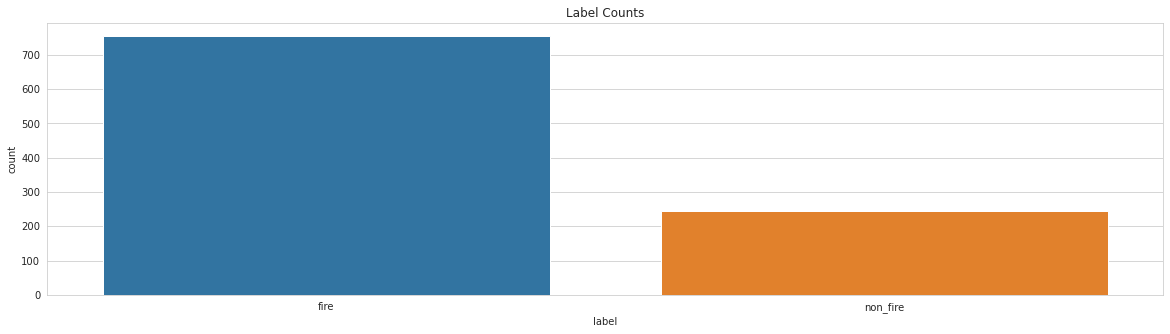

In [6]:
sns.countplot(x=df['label'], data=df)
plt.title("Label Counts");

## View the images using the path

In [7]:
from keras.preprocessing import image

def display_images(label, num_images, df):
    data = df[df['label'] == label]
    sns.set_style('dark')

    fig, ax = plt.subplots(int(num_images//2), 2, figsize=(15, 15))
    plt.suptitle(f'Images with {label}')
    ax = ax.ravel()
    for i in range((num_images//2)*2):
        path = data.sample(1).loc[:,'path'].to_numpy()[0]
        img = image.load_img(path)
        img = image.img_to_array(img)/255
        ax[i].imshow(img)
        ax[i].axes.xaxis.set_visible(False)
        ax[i].axes.yaxis.set_visible(False)

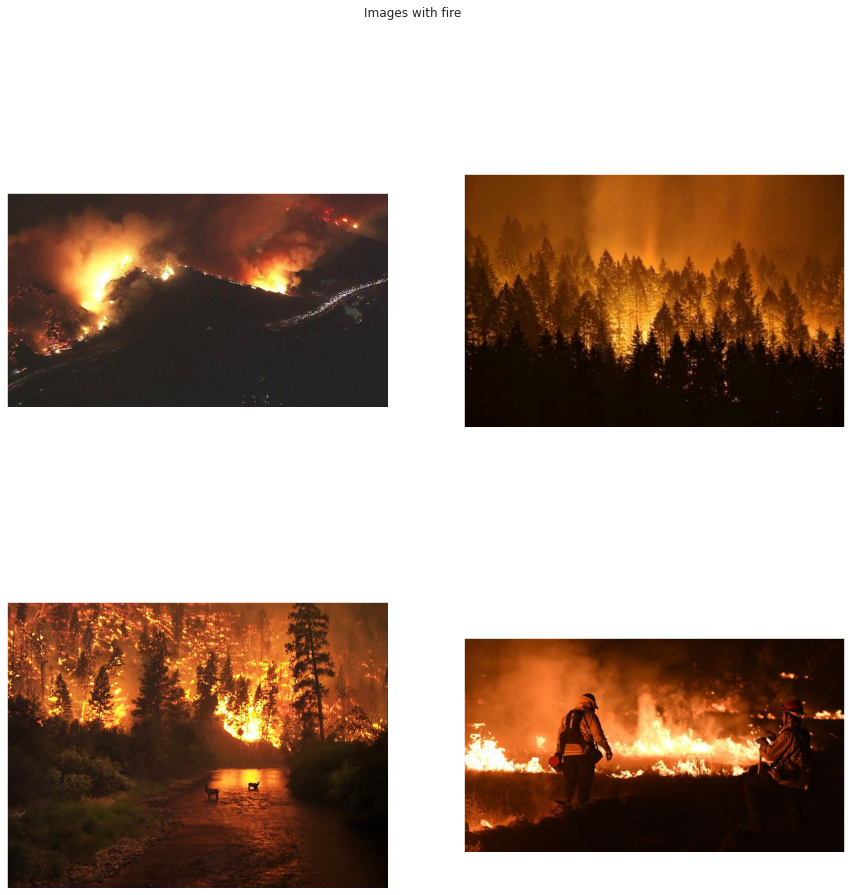

In [8]:
display_images('fire', 4, df)

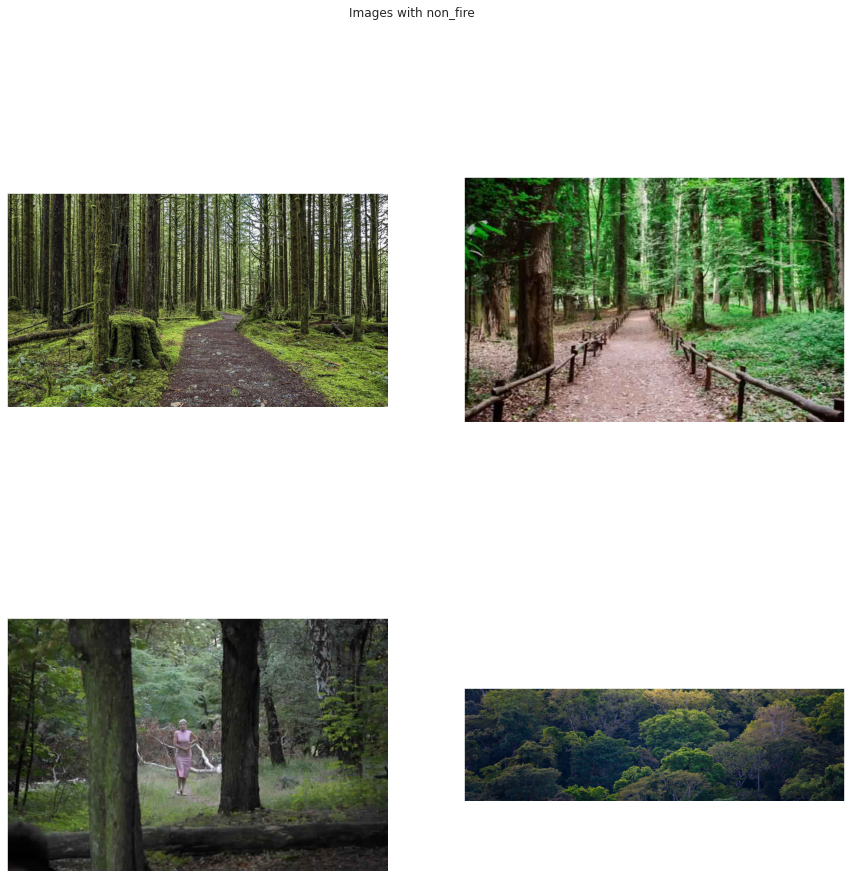

In [9]:
display_images('non_fire', 4, df)

## Get height & width of images

In [10]:
def shaper(df):
    shape=image.load_img(df['path']).size
    df['height']=shape[1]
    df['width']=shape[0]
    return df

df=df.apply(shaper, axis=1)
df.head(10)

,path,label,height,width
0,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire,540,960
1,/kaggle/input/fire-dataset/fire_dataset/non_fi...,non_fire,1136,640
2,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire,1266,1900
3,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire,513,892
4,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire,630,1200
5,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire,438,660
6,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire,1598,2400
7,/kaggle/input/fire-dataset/fire_dataset/non_fi...,non_fire,500,1170
8,/kaggle/input/fire-dataset/fire_dataset/non_fi...,non_fire,480,1280
9,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire,539,960


### Plot boxplots of image height & width

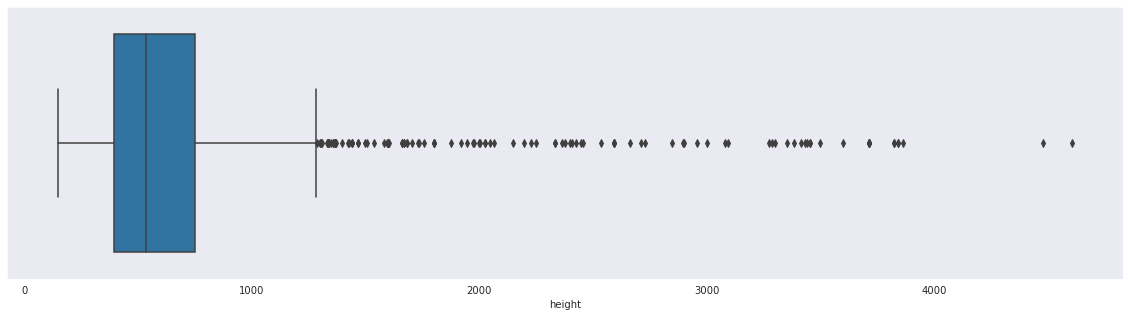

In [11]:
sns.boxplot(df['height']);

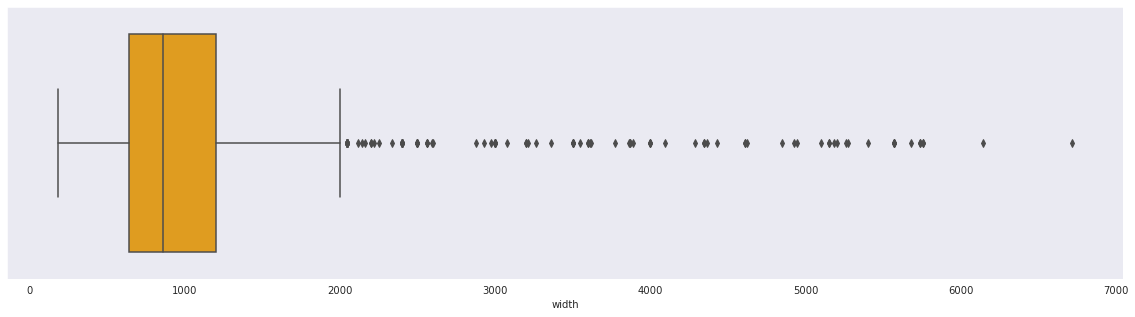

In [12]:
sns.boxplot(df['width'], color='orange');

## Image Processing

### Reshape images to size 256x256

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

In [14]:
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [15]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)

{0: 'fire', 1: 'non_fire'}


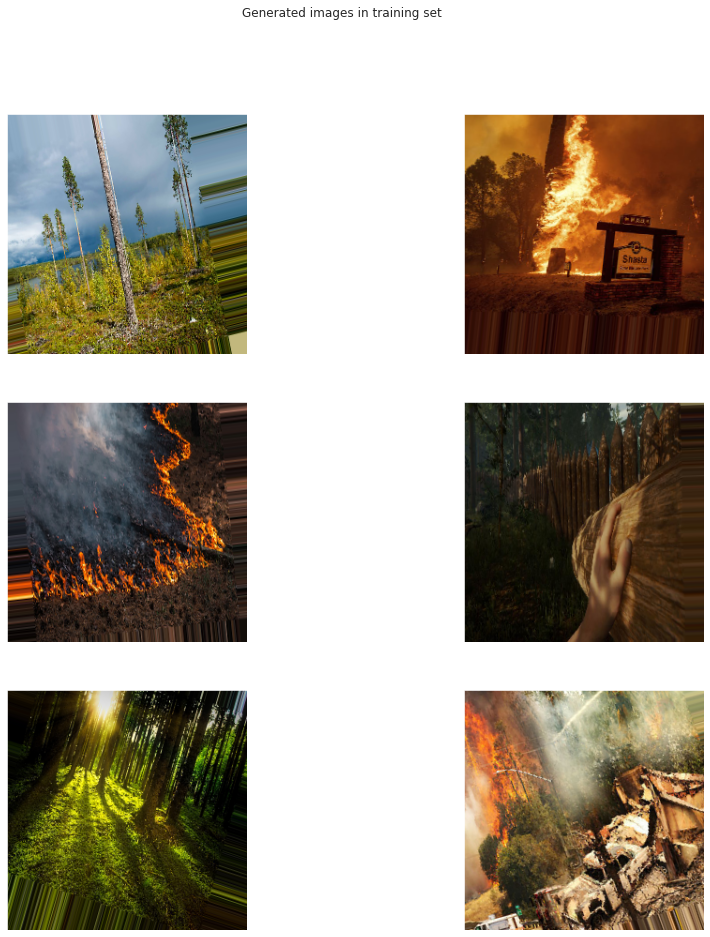

In [16]:
sns.set_style('dark')
pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Generated images in training set')
ax = ax.ravel()
for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

# Build Model

## Inception V3

2023-02-13 08:33:41.935662: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


87924736/87910968 [==============================] - 4s 0us/step


2023-02-13 08:33:50.759201: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
25/25 [==============================] - 113s 4s/step - loss: 0.4863 - accuracy: 0.8413 - val_loss: 0.0532 - val_accuracy: 0.9849
Epoch 2/10
25/25 [==============================] - 104s 4s/step - loss: 0.1578 - accuracy: 0.9563 - val_loss: 0.0311 - val_accuracy: 0.9950
Epoch 3/10
25/25 [==============================] - 104s 4s/step - loss: 0.1177 - accuracy: 0.9550 - val_loss: 0.0418 - val_accuracy: 0.9849
Epoch 4/10
25/25 [==============================] - 104s 4s/step - loss: 0.1328 - accuracy: 0.9488 - val_loss: 0.0576 - val_accuracy: 0.9698
Epoch 5/10
25/25 [==============================] - 104s 4s/step - loss: 0.1044 - accuracy: 0.9538 - val_loss: 0.0438 - val_accuracy: 0.9849
Epoch 6/10
25/25 [==============================] - 104s 4s/step - loss: 0.0846 - accuracy: 0.9750 - val_loss: 0.0499 - val_accuracy: 0.9698
Epoch 7/10
25/25 [==============================] - 104s 4s/step - loss: 0.0801 - accuracy: 0.9688 - val_loss: 0.0445 - val_accuracy: 0.9849
Epoch 8/10
25

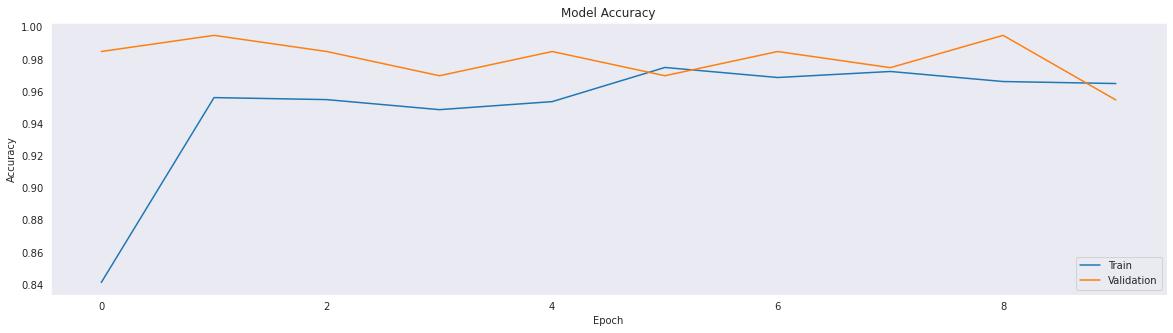

In [17]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

def build_model():
    #build the inception v3 model
    model = keras.applications.InceptionV3(include_top=False,
                                            weights='imagenet',
                                            input_shape=(256,256,3))
    # Freeze the layers
    for layer in model.layers:
        layer.trainable = False
    x = model.output
    # add a global spatial average pooling layer
    x = keras.layers.GlobalAveragePooling2D()(x)
    # add a fully-connected layer
    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    # add a logistic layer
    predictions = keras.layers.Dense(1, activation='sigmoid')(x)
    # this is the model we will train
    model = keras.Model(inputs=model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# train the model
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()